In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import itertools
import warnings

import pandas as pd
import statsmodels.api as sm 

def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

def regress_error(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    output = list(result.params)
    output.extend(list(result.bse))
    return pd.Series(output, ["slope", "intercept", "slope_e", "intercept_e"])

sns.set(style="darkgrid", palette="Set2") 

# Importing multiple plates with different layouts

In [240]:
files = [
            ["growth_data/cyrus_blue_020824.txt",
              {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met", "F": "none", "G": "Zn", "H": "B12"},
              [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
              [["A", "B", "C", "D"], ["E", "F", "G", "H"]],
              {"YkgM1": [0, 0], "MG1655": [1, 0]},
             12],

            # # good?
            #  ["growth_data/cyrus_pink_020924.txt",
            #  {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met+B12", "F": "met+Zn", "G": "met+B12+Zn", "H": "blank"},
            #  [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
            #  [["A", "B", "C", "D", "E", "F", "G"]],
            #  {"MG1655": [0, 0]},
            #   12],

             # p bad
             # ["growth_data/cyrus_blue_021324.txt",
             # {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met+B12", "F": "met+Zn", "G": "met+B12+Zn", "H": "blank"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G"]],
             # {"MG1655": [0, 0]},
             #  12],


             # also p bad
             # ["growth_data/cyrus_blue_021424.txt",
             # {"A": "met", "B": "none", "C": "B12", "D": "Zn","E": "met+B12", "F": "met+Zn", "G": "met+B12+Zn", "H": "blank"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G"]],
             # {"MG1655": [0, 0]},
             #  12],

             # ["growth_data/cyrus_blue_021524.txt",
             # {"A": "met", "B": "met", "C": "none", "D": "B12", "E": "Zn","F": "met+B12", "G": "met+Zn", "H": "met+B12+Zn"},
             # [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G"]],
             # {"MG1655": [0, 0]},
             #  12],
    
             # ["growth_data/cyrus_031524_paraquat_Mn.txt",
             # {"A": "Mn 0", "B": "Mn 1", "C": "Mn 2", "D": "Mn 3", "E": "Mn 4","F": "Mn 5", "G": "Mn 6", "H": "Mn 7"},
             # [["1", "2", "3", "4", "5", "6",], [ "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655 + PQ": [0, 0], "MG1655 - PQ": [0, 1]},
             #  12],

             # ["growth_data/cyrus_031524_paraquat_Mn_part2.txt",
             # {"A": "Mn 0", "B": "Mn 1", "C": "Mn 2", "D": "Mn 3", "E": "Mn 4","F": "Mn 5", "G": "Mn 6", "H": "Mn 7"},
             # [["1", "2", "3", "4", "5", "6",], [ "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655 + PQ": [0, 0], "MG1655 - PQ": [0, 1]},
             #  12],

             # ["growth_data/cyrus_032024_paraquat_Mn.txt",
             # {"A": "0 nM Mn", "B": "10^0 nM Mn", "C": "10^1 nM Mn", "D": "10^2 nM Mn", 
             #  "E": "10^3 nM Mn","F": "10^4 nM Mn", "G": "10^5 nM Mn", "H": "10^6 nM Mn"},
             # [["1", "2", "3", "4", "5", "6",], [ "7", "8", "9", "10", "11", "12"]],
             # [["A", "B", "C", "D", "E", "F", "G", "H"]],
             # {"MG1655 + PQ": [0, 0], "MG1655 - PQ": [0, 1]},
             #  12],
    
        ]




for i, file in enumerate(files):

    fname = file[0]
    additive = file[1]
    genotype_col = file[2]
    genotype_row = file[3]
    genotype_combinations = file[4]
    n_replicate = file[5]

    al = pl.DataFrame(additive).transpose(include_header=True)
    al = al.rename({"column": "Row", "column_0": "Additive"})
    al = al.with_columns(Plate = pl.lit(f"Plate {i+1}"))

    gl = []
    
    for genotype, idx in genotype_combinations.items():
    
        gl.extend([[genotype, x+y] for x in genotype_row[idx[0]] for y in genotype_col[idx[1]]])

    gl = pl.DataFrame(gl).transpose()
    gl = gl.rename({"column_0": "Genotype", "column_1": "Well"})
    gl = gl.with_columns(Plate = pl.lit(f"Plate {i+1}"))

    if i == 0:    
        df = pl.read_csv(fname, separator="\t") # growth_data/cyrus_mutant_013124.txt
        df = df.with_columns(Plate = pl.lit("Plate 1"))
        df = df.with_columns(N_replicate = n_replicate)
        df = df.drop('T600')

        gdf = gl
        adf = al

    else:
        df_add = pl.read_csv(fname, separator="\t")
        df_add = df_add.with_columns(Plate = pl.lit(f"Plate {i+1}"))
        df_add = df_add.with_columns(N_replicate = n_replicate)
        df_add = df_add.drop('T600')
        df = pl.concat([df, df_add])

        gdf = pl.concat([gdf, gl])
        adf = pl.concat([adf, al])

# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(df['Time'].dt.hour().cast(pl.Int64) + df['Time'].dt.minute().cast(pl.Int64) / 60 + df['Time'].dt.second() / 3600)

# get minimum OD measured, used to be 1.5
init_df = df.filter(pl.col("Time") > 1.5).sort(by="Time").drop(["Time"]).melt(id_vars=["Plate"], variable_name="Well", value_name="Initial_OD")
init_df = init_df.group_by(["Plate", "Well"]).min()

init_df_median = df.filter(pl.col("Time") < 5).sort(by="Time").drop(["Time"]).melt(id_vars=["Plate"], variable_name="Well", value_name="Initial_OD_median")
init_df_median = init_df_median.group_by(["Plate", "Well"]).median()

init_df

# blank_df.head(3)
df.head(3)

Time,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,…,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12,Plate,N_replicate
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32
0.011111,0.096,0.094,0.096,0.095,0.096,0.097,0.102,0.094,0.093,0.095,0.094,0.095,0.091,0.091,0.092,0.09,0.092,0.092,0.091,0.09,0.091,0.092,0.09,0.09,0.095,0.093,0.095,0.093,0.104,0.094,0.093,0.093,0.096,0.092,0.097,0.095,…,0.092,0.095,0.093,0.093,0.093,0.092,0.092,0.091,0.091,0.096,0.09,0.095,0.097,0.095,0.094,0.098,0.093,0.095,0.099,0.094,0.093,0.094,0.095,0.095,0.096,0.095,0.094,0.093,0.093,0.092,0.093,0.096,0.092,0.11,0.09,"""Plate 1""",12
0.036111,0.096,0.094,0.096,0.095,0.096,0.097,0.102,0.094,0.094,0.095,0.094,0.095,0.091,0.091,0.091,0.09,0.091,0.091,0.091,0.09,0.091,0.092,0.09,0.09,0.095,0.093,0.094,0.093,0.104,0.094,0.093,0.092,0.096,0.092,0.097,0.094,…,0.092,0.095,0.093,0.092,0.092,0.091,0.092,0.09,0.091,0.096,0.09,0.096,0.097,0.095,0.093,0.097,0.092,0.095,0.099,0.094,0.093,0.094,0.094,0.095,0.096,0.095,0.094,0.093,0.093,0.092,0.093,0.095,0.092,0.11,0.09,"""Plate 1""",12
0.061111,0.096,0.094,0.096,0.095,0.096,0.097,0.102,0.094,0.094,0.095,0.094,0.095,0.091,0.091,0.092,0.09,0.091,0.092,0.091,0.09,0.091,0.092,0.09,0.09,0.095,0.093,0.095,0.093,0.105,0.094,0.092,0.092,0.096,0.092,0.097,0.094,…,0.092,0.095,0.093,0.092,0.093,0.092,0.092,0.09,0.091,0.093,0.09,0.096,0.097,0.095,0.093,0.095,0.092,0.095,0.099,0.094,0.093,0.094,0.094,0.095,0.096,0.095,0.094,0.093,0.093,0.093,0.093,0.095,0.093,0.111,0.09,"""Plate 1""",12


In [241]:
# melt to experiments
mdf = df.melt(id_vars=["Time", "Plate", "N_replicate"], variable_name="Well", value_name="OD")
mdf = mdf.with_columns((mdf["Well"].str.slice(0,1)).alias("Row"))
mdf = mdf.with_columns((mdf["Well"].str.slice(1)).alias("Column"))

mdf = mdf.join(adf, on=["Plate", "Row"])
mdf = mdf.join(gdf, on=["Plate", "Well"])
mdf = mdf.join(init_df, on=["Well", "Plate"])
mdf = mdf.join(init_df_median, on=["Well", "Plate"])

mdf = mdf.with_columns(   ((pl.col("Column").cast(pl.Int32)  + pl.col("N_replicate")  - 1) %  pl.col("N_replicate") + 1).alias("Replicate"))

# mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+3) % 4 + 1).alias("Replicate"))
# mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+11) % 12 + 1).alias("Replicate"))
# mdf.group_by(["Plate","Additive","Genotype"]).size()
mdf = mdf.filter(pl.col("Genotype") == "MG1655")

In [242]:
mdf = mdf.with_columns([
    (pl.col("OD") - pl.col("Initial_OD")).alias("Initial_corrected_OD"), 
])

mdf = mdf.with_columns([
    (pl.col("OD") - pl.col("Initial_OD_median")).alias("Initial_median_corrected_OD"), 
])


mdf.head(5)

Time,Plate,N_replicate,Well,OD,Row,Column,Additive,Genotype,Initial_OD,Initial_OD_median,Replicate,Initial_corrected_OD,Initial_median_corrected_OD
f64,str,i32,str,f64,str,str,str,str,f64,f64,i32,f64,f64
0.011111,"""Plate 1""",12,"""E1""",0.098,"""E""","""1""","""met""","""MG1655""",0.098,0.102,1,0.0,-0.004
0.036111,"""Plate 1""",12,"""E1""",0.098,"""E""","""1""","""met""","""MG1655""",0.098,0.102,1,0.0,-0.004
0.061111,"""Plate 1""",12,"""E1""",0.098,"""E""","""1""","""met""","""MG1655""",0.098,0.102,1,0.0,-0.004
0.086111,"""Plate 1""",12,"""E1""",0.098,"""E""","""1""","""met""","""MG1655""",0.098,0.102,1,0.0,-0.004
0.111111,"""Plate 1""",12,"""E1""",0.098,"""E""","""1""","""met""","""MG1655""",0.098,0.102,1,0.0,-0.004


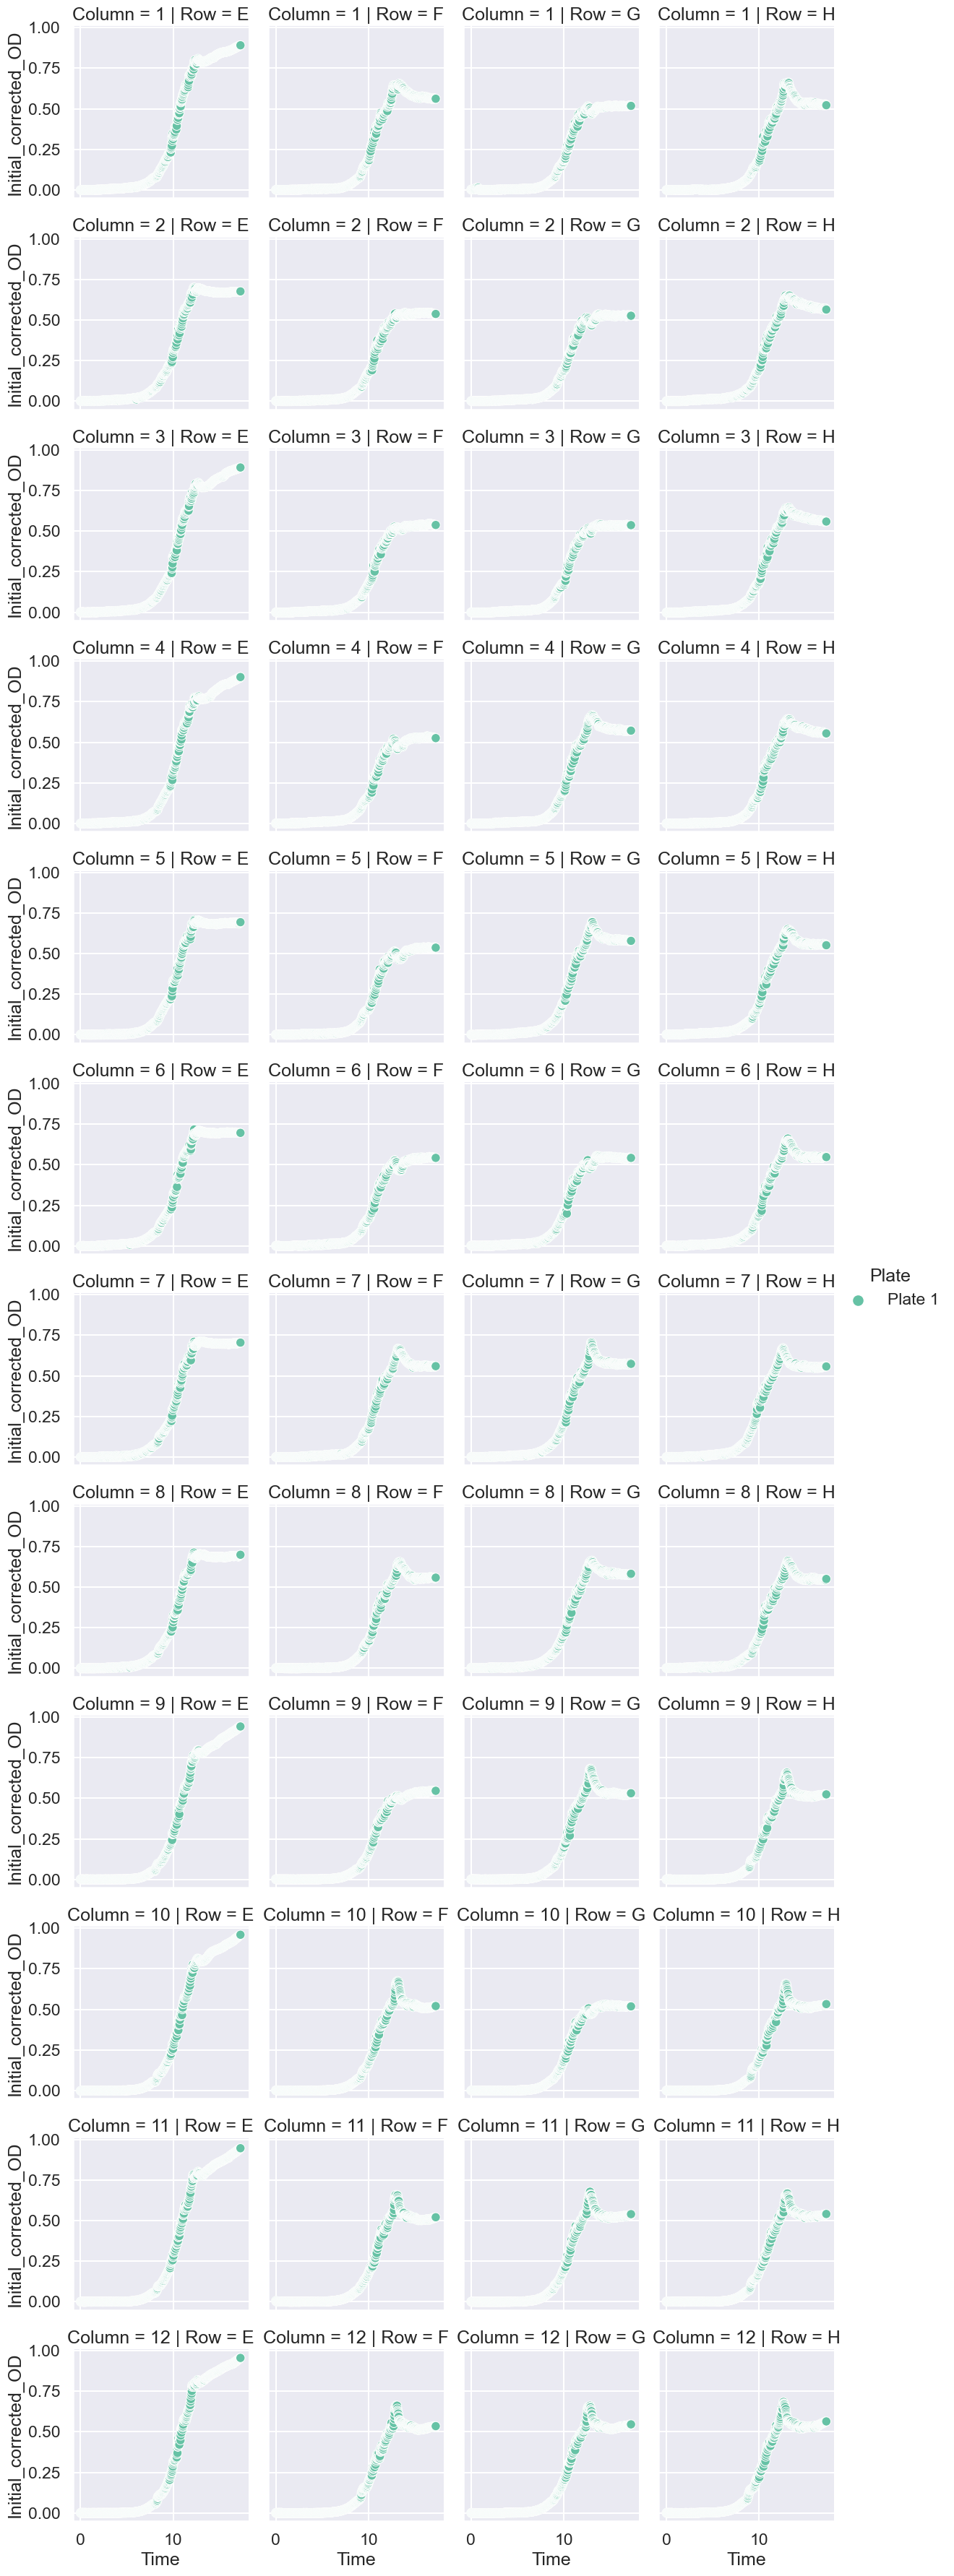

In [243]:
sns.set_context("talk")

sns.relplot(x="Time", y="Initial_corrected_OD", hue="Plate", col="Row", row="Column", \
            # row="Genotype", 
            height=3, \
            # col_wrap=4,
            data=mdf)

In [244]:
f_mdf = mdf.filter(pl.col("Time") > 1.5).filter(pl.col("Initial_corrected_OD") > 0)

f_mdf = f_mdf.with_columns([
    ((pl.col("Initial_corrected_OD")).log())
    .alias("Log_initial_corrected_OD")
])

f_mdf = f_mdf.drop_nulls()

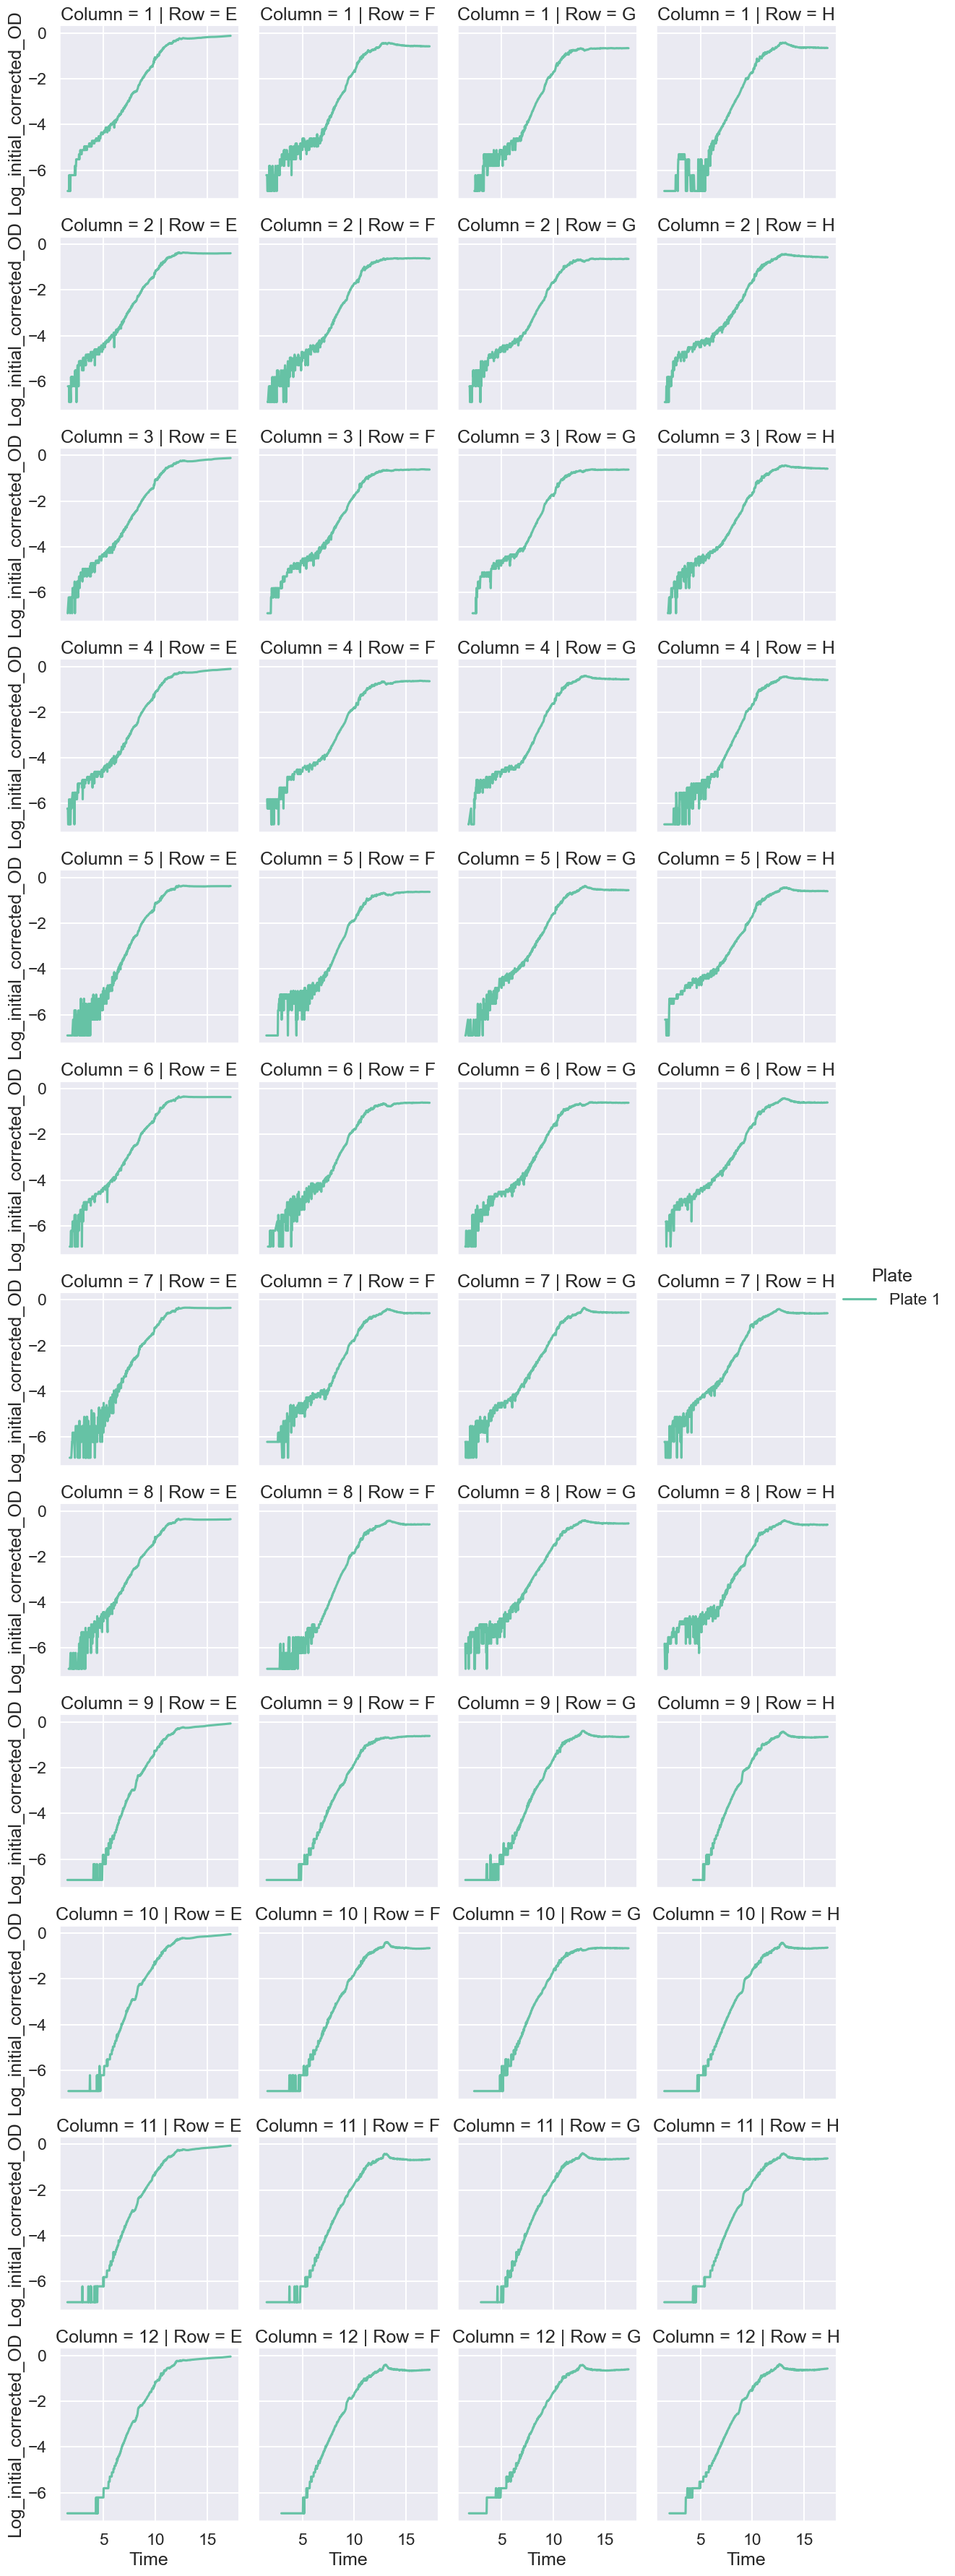

In [245]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Plate", kind="line", row="Column", col="Row", height=3, \
                data=f_mdf.filter(pl.col("Time") < 20))

# plt.savefig("weird_plate.png")

In [246]:
gr_df = f_mdf.filter( (pl.col("Time") < 20))
minimum_start_times = gr_df.filter(pl.col("Log_initial_corrected_OD") <= -5.5).group_by(["Plate", "Well"]).agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = gr_df.filter(pl.col("Log_initial_corrected_OD") >= -3).group_by(["Plate", "Well"]).agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

gr_df = gr_df.join(minimum_start_times, on=["Plate", "Well"])
gr_df = gr_df.join(minimum_end_times, on=["Plate", "Well"])
gr_df = gr_df.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_df = gr_df.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))
gr_df.head(5)

# regress and pick top x 
predicted_gr = gr_df \
.to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time']).reset_index()

M = 0
N = 3
top_gr = pl.DataFrame(predicted_gr.sort_values(by=["Genotype", "Additive", "Plate", "slope"], ascending=False).groupby(['Genotype', 'Additive', 'Plate']).nth[M:N])
top_gr.head(7)

gr_df = gr_df.join(top_gr, on=["Additive", "Plate", "Replicate", "Genotype"])

/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_89484/2521229149.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time']).reset_index()


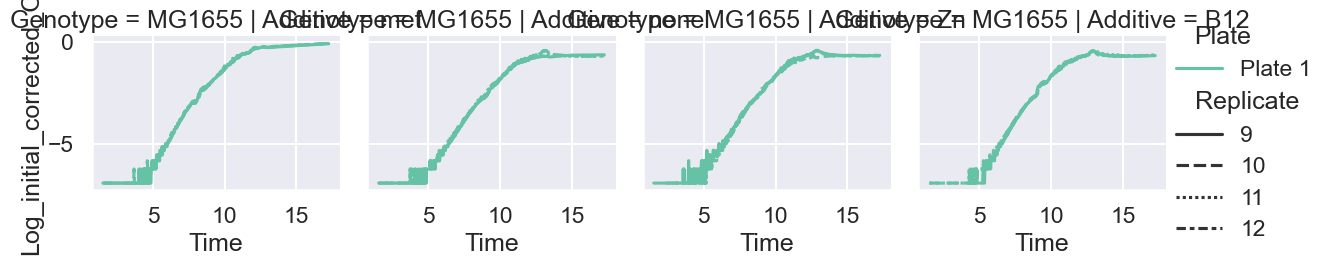

In [247]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Plate", kind="line", row="Genotype", col="Additive", style="Replicate", height=3, \
                data=f_mdf.join(top_gr, on=["Additive", "Plate", "Replicate", "Genotype"]))

# plt.savefig("weird_plate.png")

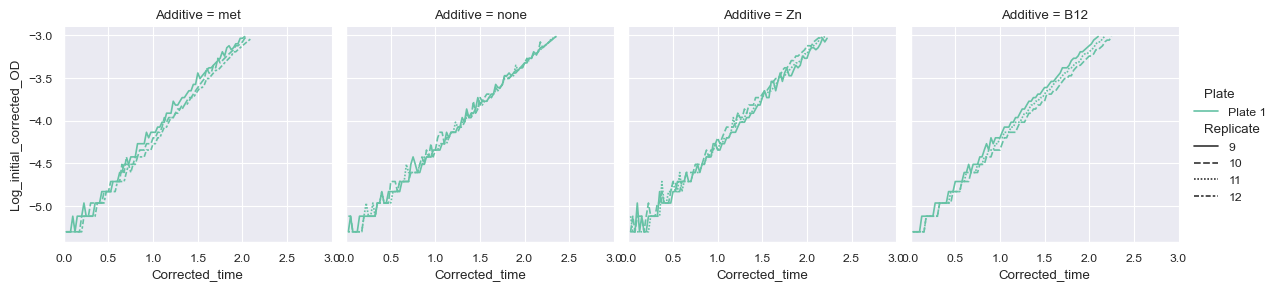

In [248]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.set_context("paper")
    sns.relplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Plate", kind="line", col="Additive", style="Replicate", 
                col_wrap=4, 
                # row="Genotype",
                height=3, \
                data=gr_df)
    
    plt.xlim([0,3])

# plt.savefig("plates.png")

(0.0, 3.0)

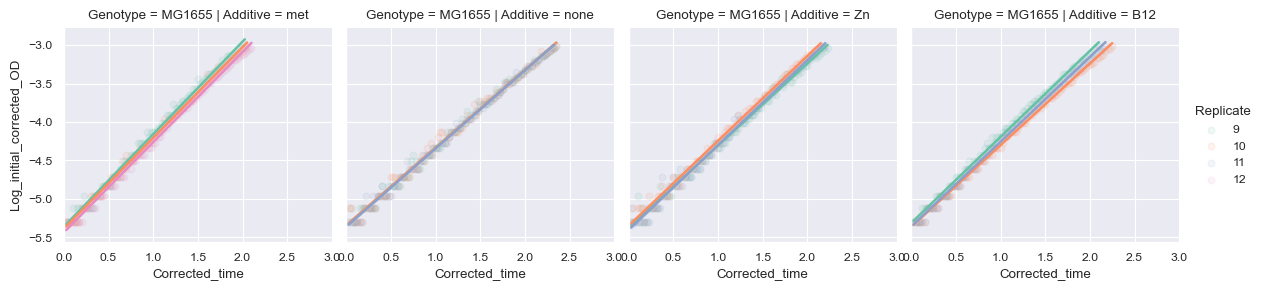

In [249]:
sns.lmplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Replicate", col="Additive", 
           # col_wrap=4,  \
           row="Genotype",
           height=3,
           data=gr_df.to_pandas(), scatter_kws = {"alpha": 0.1})

plt.xlim([0,3])


In [250]:
# sns.relplot(x="Time", y="Log_initial_corrected_OD", kind="line", row="Replicate", col="Additive", height=3, \
#             data=f_mdf.filter(pl.col("Time") < 15))

In [251]:
# sns.set_context("paper")

# sns.relplot(x="Time", y="Initial_corrected_OD", hue="Plate", style="Replicate", kind="scatter", col="Additive", \
#             # row="Genotype", height=3, \
#             col_wrap=4,
#             data=mdf)

In [252]:
predicted_gr = gr_df \
.to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time'])
predicted_gr["doubling_time"] = np.log(2) / predicted_gr["slope"]
predicted_gr = predicted_gr.reset_index()


gr_mean_std = predicted_gr.groupby(['Genotype', 'Additive']).agg({'slope':['mean','std']})
gr_mean_std.columns = gr_mean_std.columns.get_level_values(1)
gr_mean_std["doubling_time"] = np.log(2)/gr_mean_std["mean"]
# gr_mean_std = gr_mean_std.reset_index()

predicted_gr["doubling_time"] = np.log(2)/predicted_gr["slope"]
predicted_gr

/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_89484/544480332.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time'])


,Genotype,Additive,Replicate,Plate,slope,intercept,slope_e,intercept_e,doubling_time
0,MG1655,B12,9,Plate 1,1.118869,-5.313048,0.007333,0.008970,0.619507
1,MG1655,B12,10,Plate 1,1.060833,-5.362261,0.005396,0.007068,0.653399
2,MG1655,B12,11,Plate 1,1.102755,-5.360212,0.006421,0.008133,0.628560
3,MG1655,Zn,9,Plate 1,1.068039,-5.374192,0.010509,0.013613,0.648991
4,MG1655,Zn,10,Plate 1,1.102385,-5.346272,0.009394,0.011763,0.628771
5,MG1655,Zn,11,Plate 1,1.102021,-5.400372,0.010958,0.014036,0.628978
6,MG1655,met,9,Plate 1,1.202491,-5.360460,0.010636,0.012550,0.576426
7,MG1655,met,10,Plate 1,1.180368,-5.386435,0.008078,0.009648,0.587230
8,MG1655,met,12,Plate 1,1.172544,-5.434108,0.007222,0.008835,0.591148
9,MG1655,none,9,Plate 1,1.010952,-5.345920,0.007981,0.010914,0.685638


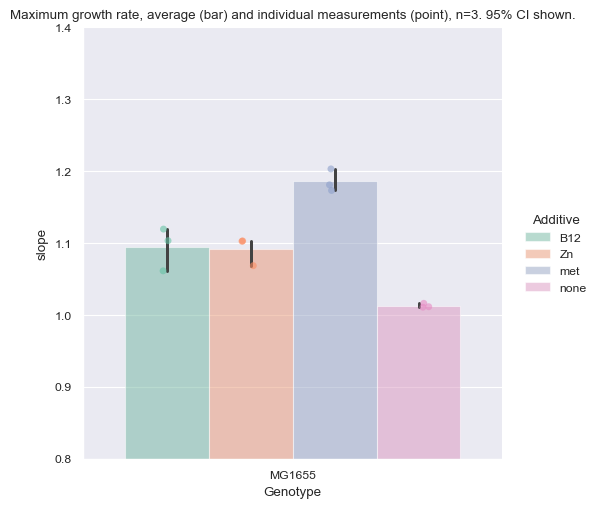

In [253]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    filter_df = pl.DataFrame(predicted_gr) # .filter((pl.col("Genotype") == "MG1655 - PQ"))
    filter_df.head(5)
    
    g = sns.catplot(x="Genotype", y="slope", hue="Additive", 
                    data=filter_df.to_pandas(), kind="bar",  
                    height=5, aspect=1, alpha=0.5, errorbar="ci",
                    # col="Plate", col_wrap=3
                       );
    g.map_dataframe(sns.stripplot, x="Genotype", y="slope", 
                    hue="Additive", palette="Set2",
                    alpha=0.6, dodge=True)
    
    plt.title("Maximum growth rate, average (bar) and individual measurements (point), n=3. 95% CI shown.")
    plt.ylim([0.8, 1.4])
    
    plt.show()
    
   #  g.savefig("story1.png")

In [254]:
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
    
#     filter_df = pl.DataFrame(predicted_gr).filter((pl.col("Genotype") == "MG1655"))
#     filter_df.head(5)
    
#     g = sns.catplot(x="Genotype", y="slope", hue="Additive", 
#                     data=filter_df.to_pandas(), kind="bar", 
#                     height=5, aspect=1, alpha=0.5, hue_order=["none", "Zn", "B12", "met"], errorbar="ci");
#     g.map_dataframe(sns.stripplot, x="Genotype", y="slope", 
#                     hue="Additive", palette="Set2",
#                     alpha=0.6, dodge=True, hue_order=["none", "Zn", "B12", "met"])
    
#     plt.title("Minimum doubling time, average (bar) and individual measurements (point), n=3. 95% CI shown.")
#     plt.ylim([1, 1.3])
    
#     plt.show()
    
#    #  g.savefig("story1.png")

In [225]:
sns.lmplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Additive", 
           # col_wrap=4,  \
           # hue_order=["none", "Zn", "B12", "met"],
           col="Genotype",
           height=5,
           data=gr_df.filter((pl.col("Genotype") == "MG1655")).to_pandas(), scatter_kws = {"alpha": 0.1})

plt.xlim([0, 1.5])


ValueError: Number of columns must be a positive integer, not 0

<Figure size 0x500 with 0 Axes>

In [166]:
# sns.lmplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Additive", 
#            # col_wrap=4,  \
#            hue_order=["none", "Zn", "B12", "met"],
#            col="Genotype",
#            height=5,
#            data=gr_df.filter((pl.col("Genotype") == "MG1655")).to_pandas(), scatter_kws = {"alpha": 0.1})

# plt.xlim([0, 1.5])


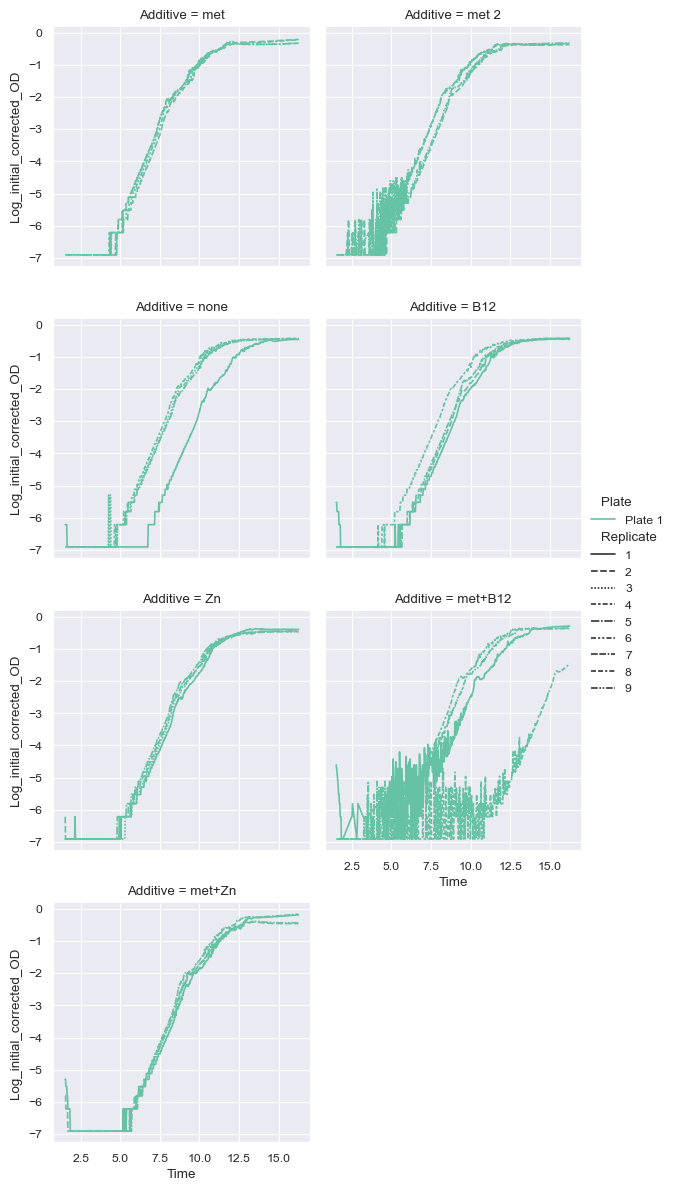

In [167]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Plate", kind="line", col="Additive", style="Replicate", 
                height=3, \
                col_wrap=2, 
                data=f_mdf.join(top_gr, on=["Additive", "Plate", "Replicate", "Genotype"]).filter((pl.col("Genotype") == "MG1655"))   )

# plt.savefig("weird_plate.png")